![alt text](https://images.ctfassets.net/22n7d68fswlw/aqZGiWDymcgIKgQk46ggs/294832f7df0760087069072fc1a312c6/imdb_top_250_movie_poster_by_saxon1964-d38rnod.jpg?w=1200)

## Classification de critiques de films

Nous allons créer un Feed-Dorward Deep Neural Network pour faire la classification d'une critique d'un film comme positive ou négative.  

Pour ce faire, R, Keras et un ensemble de données de IMDB qui contient des critiques et une variable qui représente la positivité de cette critique sont utilisés.


Pour commencer, l'importation des différentes libraries qui seront utilisés dans le programme pour faire le classificateur. 

- **keras**: Une abstraction de haut niveau de Tensorflow, une librairie développée par Google pour le deep learning en python. 
- **dplyr**: Librairie pour faire des manipulation de données, principalement utilisé pour la préparation des données ici.
- **ggplot2**: Permet de créé des graphique.
- **purrr**: Permet certain raccourcis de programmation fonctionnel.

In [130]:
# https://github.com/rstudio/keras/issues/147
library(keras)
library(dplyr)
library(ggplot2)
library(purrr)

### Téléchargement de l'ensemble de données
Nous téléchargons l'ensemble de données IMDB qui a déjà été prétraité pour etre représenté sous forme d'indice a la place de mots. Chaque index représente un mot. Les indeces des 10 000 mots les plus fréquents sont utilisés. Les données sont déjà séparer en *train/test* avec 2 500 entrés chancun.

In [160]:
vocab_size <- 10000
imdb <- dataset_imdb(num_words = vocab_size)

c(train_data, train_labels) %<-% imdb$train
c(test_data, test_labels) %<-% imdb$test

word_index <- dataset_imdb_word_index()

train_data[[1]]

[1]    1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941    4
 [16]  173   36  256    5   25  100   43  838  112   50  670    2    9   35  480
 [31]  284    5  150    4  172  112  167    2  336  385   39    4  172 4536 1111
 [46]   17  546   38   13  447    4  192   50   16    6  147 2025   19   14   22
 [61]    4 1920 4613  469    4   22   71   87   12   16   43  530   38   76   15
 [76]   13 1247    4   22   17  515   17   12   16  626   18    2    5   62  386
 [91]   12    8  316    8  106    5    4 2223 5244   16  480   66 3785   33    4
[106]  130   12   16   38  619    5   25  124   51   36  135   48   25 1415   33
[121]    6   22   12  215   28   77   52    5   14  407   16   82    2    8    4
[136]  107  117 5952   15  256    4    2    7 3766    5  723   36   71   43  530
[151]  476   26  400  317   46    7    4    2 1029   13  104   88    4  381   15
[166]  297   98   32 2071   56   26  141    6  194 7486   18    4  226   22   21
[181]  134  476   26  480    5  144   30 5535   18   51   36   28  224   92   25
[196]  104    4  226   65   16   38 1334   88   12   16  283    5   16 4472  113
[211]  103   32   15   16 5345   19  178   32

### Affichage du texte
Il est possible de remplacer les indexes par la valeur textuel qui leurs correspondes pour visualiser le texte original de la critique.

In [161]:
word_index_df <- data.frame(
  word = names(word_index),
  idx = unlist(word_index, use.names = FALSE),
  stringsAsFactors = FALSE
)

word_index_df <- word_index_df %>% mutate(idx = idx + 3)
word_index_df <- word_index_df %>%
  add_row(word = "<PAD>", idx = 0)%>%
  add_row(word = "<START>", idx = 1)%>%
  add_row(word = "<UNK>", idx = 2)%>%
  add_row(word = "<UNUSED>", idx = 3)

word_index_df <- word_index_df %>% arrange(idx)

head(word_index_df, 15)

decode_review <- function(text){
  paste(map(text, function(number) word_index_df %>%
              filter(idx == number) %>%
              select(word) %>% 
              pull()),
        collapse = " ")
}

decode_review(train_data[[1]])

word,idx
<PAD>,0
<START>,1
<UNK>,2
<UNUSED>,3
the,4
and,5
a,6
of,7
to,8
is,9


[1] "<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all"

### Longueur des *inputs*
Les inputs d'un *neural network* doivent être de la même grandeur. En ce moment, les critiques ont des longueurs différentes. Nous allons donc mettre une longueur maximum (256) et couper les *inputs* trop grand et remplire les critiques trop courte avec des 0, qui représente un *padding*.

In [162]:
paste("Longueur #1:", length(train_data[[1]]), ", Longueur #2: ", length(train_data[[2]]))

train_data <- pad_sequences(
  train_data,
  value = word_index_df %>% filter(word == "<PAD>") %>% select(idx) %>% pull(),
  padding = "post",
  maxlen = 256
)

test_data <- pad_sequences(
  test_data,
  value = word_index_df %>% filter(word == "<PAD>") %>% select(idx) %>% pull(),
  padding = "post",
  maxlen = 256
)

paste("Longueur #1:", length(train_data[1, ]), ", Longueur #2: ", length(train_data[2, ]))

train_data[1, ]

[1] "Longueur #1: 218 , Longueur #2:  189"

[1] "Longueur #1: 256 , Longueur #2:  256"

[1]    1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941    4
 [16]  173   36  256    5   25  100   43  838  112   50  670    2    9   35  480
 [31]  284    5  150    4  172  112  167    2  336  385   39    4  172 4536 1111
 [46]   17  546   38   13  447    4  192   50   16    6  147 2025   19   14   22
 [61]    4 1920 4613  469    4   22   71   87   12   16   43  530   38   76   15
 [76]   13 1247    4   22   17  515   17   12   16  626   18    2    5   62  386
 [91]   12    8  316    8  106    5    4 2223 5244   16  480   66 3785   33    4
[106]  130   12   16   38  619    5   25  124   51   36  135   48   25 1415   33
[121]    6   22   12  215   28   77   52    5   14  407   16   82    2    8    4
[136]  107  117 5952   15  256    4    2    7 3766    5  723   36   71   43  530
[151]  476   26  400  317   46    7    4    2 1029   13  104   88    4  381   15
[166]  297   98   32 2071   56   26  141    6  194 7486   18    4  226   22   21
[181]  134  476   26  480    5  144   30 5535   18   51   36   28  224   92   25
[196]  104    4  226   65   16   38 1334   88   12   16  283    5   16 4472  113
[211]  103   32   15   16 5345   19  178   32    0    0    0    0    0    0    0
[226]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
[241]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
[256]    0

## EXPLANATION

In [136]:
x_val <- train_data[1:10000, ]
partial_x_train <- train_data[10001:nrow(train_data), ]

y_val <- train_labels[1:10000]
partial_y_train <- train_labels[10001:length(train_labels)]

## EXPLANATION

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
embedding_18 (Embedding)            (None, None, 16)                160000      
________________________________________________________________________________
global_average_pooling1d_18 (Global (None, 16)                      0           
________________________________________________________________________________
dense_52 (Dense)                    (None, 16)                      272         
________________________________________________________________________________
dropout_7 (Dropout)                 (None, 16)                      0           
________________________________________________________________________________
dense_53 (Dense)                    (None, 16)                      272         
________________________________________________________________________________
dropout_8 (Dropout)         

$loss
[1] 0.6347643

$acc
[1] 0.85732

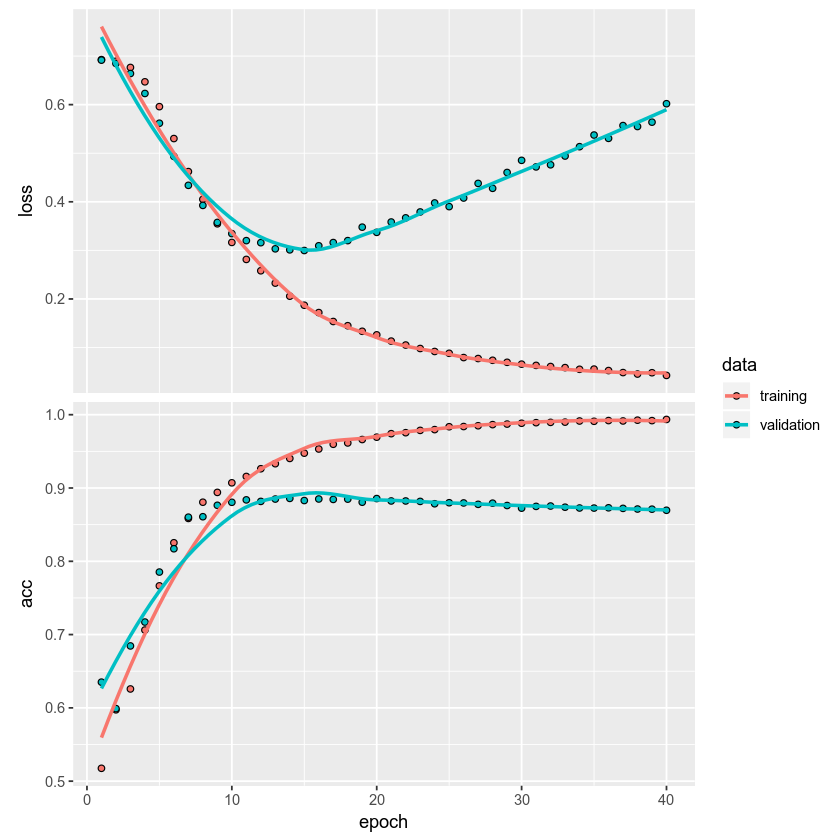

In [137]:
model <- keras_model_sequential()
model %>% 
    layer_embedding(input_dim = vocab_size, output_dim = 16) %>%
    layer_global_average_pooling_1d() %>%
    layer_dense(units = 16, activation = "relu") %>%
    layer_dropout(rate = 0.4) %>%
    layer_dense(units = 16, activation = "relu") %>%
    layer_dropout(rate = 0.3) %>%
    layer_dense(units = 1, activation = "sigmoid")

model %>% summary()

model %>% compile(
  optimizer = 'adam',
  loss = 'binary_crossentropy',
  metrics = list('accuracy')
)

history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 40,
  batch_size = 512,
  validation_data = list(x_val, y_val),
  verbose=1
)

plot(history)
model %>% evaluate(test_data, test_labels)

## EXPLANATION

$loss
[1] 0.3101648

$acc
[1] 0.87768

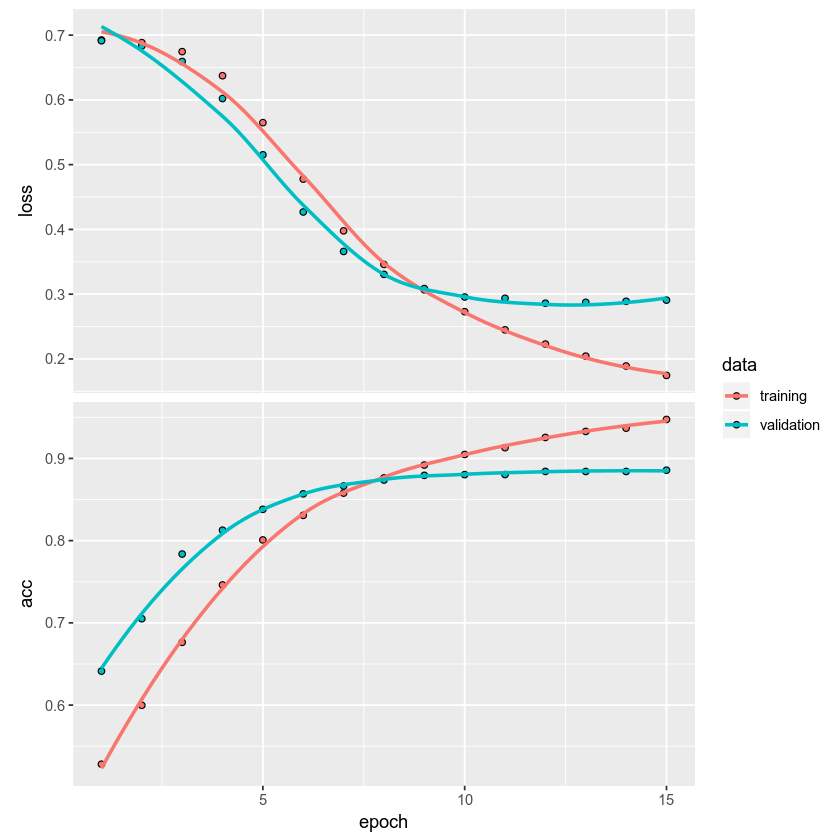

In [138]:
model <- keras_model_sequential()
model %>% 
    layer_embedding(input_dim = vocab_size, output_dim = 16) %>%
    layer_global_average_pooling_1d() %>%
    layer_dense(units = 16, activation = "relu") %>%
    layer_dropout(rate = 0.4) %>%
    layer_dense(units = 16, activation = "relu") %>%
    layer_dropout(rate = 0.3) %>%
    layer_dense(units = 1, activation = "sigmoid")

model %>% compile(
  optimizer = 'adam',
  loss = 'binary_crossentropy',
  metrics = list('accuracy')
)

history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 15,
  batch_size = 512,
  validation_data = list(x_val, y_val),
  verbose=1
)

plot(history)
model %>% evaluate(test_data, test_labels)